# Multiple features model

## Model description

** Find out how IQ, Years Experience, and Age affects income with the data **

## Creating Model and Data

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf

In [2]:
# create dataset
np.random.seed(555)
iq = np.random.normal(100, 20,500).astype(int) # IQ
user_exp = np.random.normal(20, 10, 500)
age = np.random.normal(40, 15, 500).astype(int) # age
dob = np.datetime64('2018-06-04') - 365 * age  # data of birth 

b = 5
er = np.random.normal(0, 1.5, 500)

Y = np.array([0.3*x1 + 1.5*x2 + 0.83*x3 + b + e for x1,x2,x3,e in zip(iq, user_exp, age, er) ])

## Data Cleaning

In [3]:
cols = ['iq', 'years_experience', 'dob']
df = pd.DataFrame(list(zip(iq, user_exp, dob)), columns=cols)
df['income'] = Y
df.head()

,iq,years_experience,dob,income
0,102,25.186089,1973-06-15,110.809409
1,107,26.441323,1971-06-16,117.121895
2,78,28.502783,1980-06-13,102.860987
3,104,37.539534,2002-06-08,107.422564
4,96,24.165349,1965-06-17,112.635830


In [4]:
df.describe()

,iq,years_experience,income
count,500.000000,500.000000,500.000000
mean,98.500000,19.577058,96.494435
std,20.648164,10.010686,20.179551
min,29.000000,-6.365446,35.466865
25%,84.000000,13.105207,83.440439
50%,99.000000,19.070107,95.789628
75%,112.000000,26.199558,108.935810
max,152.000000,49.486140,154.546053


In [5]:
df = df[df.years_experience >=0 ]
df.describe()
df.head()

,iq,years_experience,dob,income
0,102,25.186089,1973-06-15,110.809409
1,107,26.441323,1971-06-16,117.121895
2,78,28.502783,1980-06-13,102.860987
3,104,37.539534,2002-06-08,107.422564
4,96,24.165349,1965-06-17,112.635830


## Exploratory Data Analysis

In [6]:
df.describe(include=['datetime64'])

,dob
count,487
unique,71
top,1977-06-14 00:00:00
freq,18
first,1932-06-25 00:00:00
last,2029-06-01 00:00:00


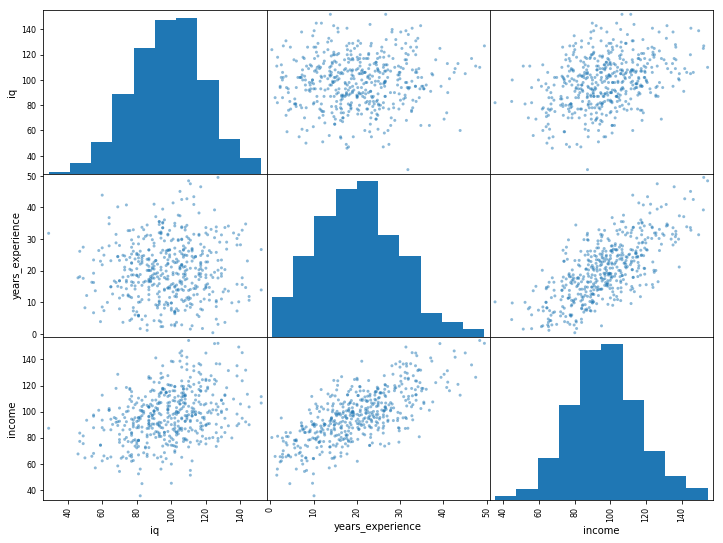

In [7]:
import matplotlib.pyplot as plt
%matplotlib inline

pd.plotting.scatter_matrix(df, figsize=(12,9));

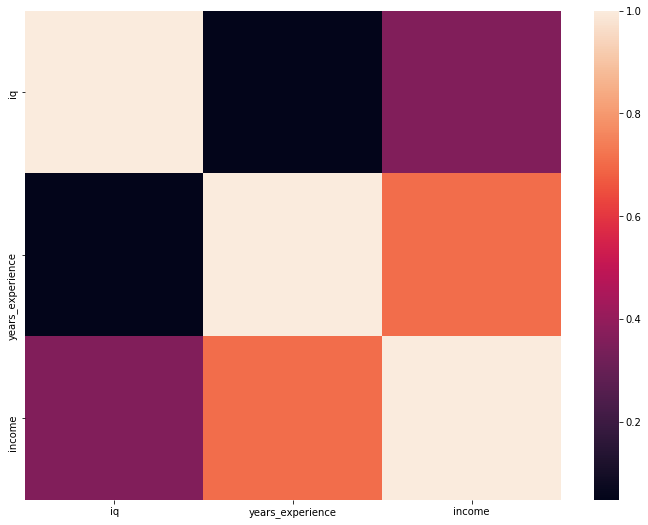

In [8]:
import seaborn as sns
plt.figure(figsize=(12,9))
sns.heatmap(df.corr());

## Data Processing / Feature Engineering

In [9]:
from datetime import datetime as dt

df['age'] = df.dob.apply(lambda x: (dt.strptime('2017-10-31', '%Y-%m-%d') - x).days/365)
df.drop('dob', axis=1, inplace=True)
df.head()

,iq,years_experience,income,age
0,102,25.186089,110.809409,44.408219
1,107,26.441323,117.121895,46.408219
2,78,28.502783,102.860987,37.408219
3,104,37.539534,107.422564,15.408219
4,96,24.165349,112.635830,52.408219


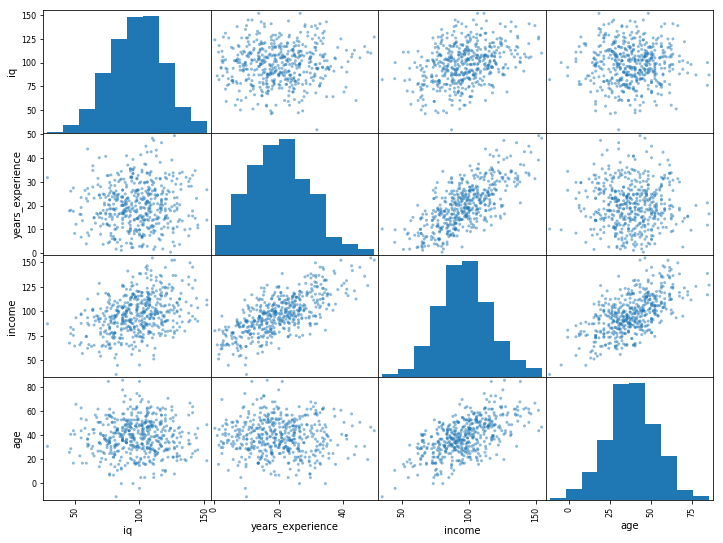

In [10]:
pd.plotting.scatter_matrix(df, figsize=(12,9));

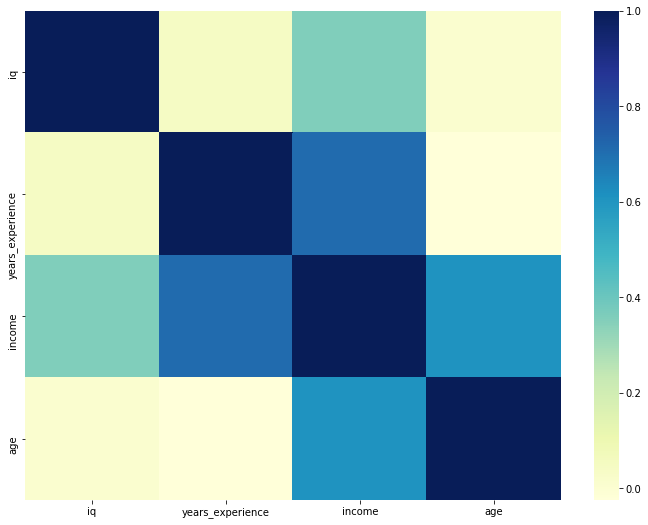

In [11]:
plt.figure(figsize=(12,9))
sns.heatmap(df.corr(),  cmap="YlGnBu");

## Train/Evaluate Models

In [12]:
X = df.iloc[:, [0,1,3]]
Y = df.income

tr_idx = X.sample(frac=0.7).index
Xtr = X[X.index.isin(tr_idx)].values
Xts = X[~X.index.isin(tr_idx)].values

Ytr = Y[Y.index.isin(tr_idx)].values
Yts = Y[~Y.index.isin(tr_idx)].values

X.head()

,iq,years_experience,age
0,102,25.186089,44.408219
1,107,26.441323,46.408219
2,78,28.502783,37.408219
3,104,37.539534,15.408219
4,96,24.165349,52.408219


## Create Model

In [13]:
# init graph
tf.reset_default_graph()
sess = tf.Session()

In [14]:
# create parameters
w = tf.get_variable(name='w', initializer=[[0.1], [0.1], [0.1]])
tf.summary.scalar('wmean', tf.reduce_mean(w))
tf.summary.scalar('wsum', tf.reduce_sum(w))
tf.summary.scalar('weights', tf.reduce_sum(w))
tf.summary.histogram('weights', w)

b = tf.get_variable(name='b', initializer=0.)
tf.summary.scalar('intercept', b)

# create input placeholders
x = tf.placeholder('float32', name='x')
y = tf.placeholder('float32', name='y_true')

# create linear model
yhat = tf.reshape(tf.matmul(x,w) + b, [-1,], name='yhat')

In [15]:
import os

mse = tf.reduce_mean(tf.square(y - yhat), name='mse')
rmse = tf.sqrt(mse, name='rmse')
tf.summary.scalar('loss_rmse', rmse)

# test score
test_nrmse = tf.divide(rmse, tf.abs(tf.reduce_mean(y)), name='nrmse')
tf.summary.scalar('test_nrmse', test_nrmse)

# merge all summaries and create a writer object that will write during training
summaries = tf.summary.merge_all()
writer = tf.summary.FileWriter(logdir='./multiple-features/linear_logs', graph=sess.graph)

In [16]:
# init vars
init = tf.variables_initializer([w, b])
sess.run(init)

## Training/Evaluation

In [17]:
# run optimization again with smaller learning rate
opt = tf.train.GradientDescentOptimizer(learning_rate=0.001)
train = opt.minimize(rmse)
        
for i in range(2000):
    if (i%50 == 0) & (i > 0):
        smry, nrmse = sess.run([summaries, test_nrmse], {x: Xts, y: Yts})
        writer.add_summary(smry, i)
        print('Test NRMSE: {}'.format(nrmse))
    else:
        smry, _ = sess.run([summaries, train], {x: Xtr, y: Ytr})
        writer.add_summary(smry, i)

Test NRMSE: 0.10914141684770584
Test NRMSE: 0.054966941475868225
Test NRMSE: 0.06369039416313171
Test NRMSE: 0.06193999573588371
Test NRMSE: 0.06139605864882469
Test NRMSE: 0.06267362833023071
Test NRMSE: 0.06091645732522011
Test NRMSE: 0.06283944100141525
Test NRMSE: 0.060817137360572815
Test NRMSE: 0.06287465244531631
Test NRMSE: 0.06079655513167381
Test NRMSE: 0.06288190931081772
Test NRMSE: 0.060792580246925354
Test NRMSE: 0.06288325786590576
Test NRMSE: 0.06079201027750969
Test NRMSE: 0.06288345158100128
Test NRMSE: 0.0607922188937664
Test NRMSE: 0.06288322061300278
Test NRMSE: 0.06079261749982834
Test NRMSE: 0.06288304924964905
Test NRMSE: 0.06079297885298729
Test NRMSE: 0.06288288533687592
Test NRMSE: 0.06079334393143654
Test NRMSE: 0.06288260221481323
Test NRMSE: 0.06079373508691788
Test NRMSE: 0.06288234889507294
Test NRMSE: 0.06079408898949623
Test NRMSE: 0.0628821849822998
Test NRMSE: 0.060794588178396225
Test NRMSE: 0.06288189440965652
Test NRMSE: 0.06079492345452309
Test N

In [18]:
sess.run([w,b])

[array([[0.29259577],
        [1.5111967 ],
        [0.83537996]], dtype=float32), 0.06225326]

## Linear Regressor

In [61]:
# init graph
tf.reset_default_graph()
sess = tf.Session()
w = tf.get_variable(name='w', initializer=[[0.1], [0.1], [0.1]])
b = tf.get_variable(name='b', initializer=0.)

In [62]:
x_data = df.drop(['income'],axis=1)
y_val = df['income']

In [63]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(x_data,y_val,test_size=0.3,random_state=101)

In [64]:
df.columns
X_train.head()

,iq,years_experience,age
492,131,3.605921,41.408219
450,145,11.804424,45.408219
402,87,13.927063,45.408219
113,120,17.775770,27.408219
96,102,15.055042,49.408219


In [65]:
# features
feat_iq = tf.feature_column.numeric_column('iq')
feat_years_exp = tf.feature_column.numeric_column('years_experience')
feat_age = tf.feature_column.numeric_column('age')

feat_cols = [feat_iq,feat_years_exp,feat_age]
estimator = tf.estimator.LinearRegressor(feature_columns=feat_cols)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': '/var/folders/nk/v2fqyl0s6b3gtb2h34pw9pdm0000gp/T/tmpvfm8wnwz', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': None, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x11bdf4f98>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


** Training the model **

In [66]:
# input functions

input_func = tf.estimator.inputs.pandas_input_fn(x=X_train,y=y_train ,batch_size=10,num_epochs=1000,
                                            shuffle=True)

In [67]:
estimator.train(input_fn=input_func,steps=1000)

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 1 into /var/folders/nk/v2fqyl0s6b3gtb2h34pw9pdm0000gp/T/tmpvfm8wnwz/model.ckpt.
INFO:tensorflow:loss = 98638.83, step = 1
INFO:tensorflow:global_step/sec: 589.939
INFO:tensorflow:loss = 280.42117, step = 101 (0.172 sec)
INFO:tensorflow:global_step/sec: 498.658
INFO:tensorflow:loss = 86.70006, step = 201 (0.200 sec)
INFO:tensorflow:global_step/sec: 752.095
INFO:tensorflow:loss = 116.20681, step = 301 (0.131 sec)
INFO:tensorflow:global_step/sec: 762.469
INFO:tensorflow:loss = 63.596752, step = 401 (0.131 sec)
INFO:tensorflow:global_step/sec: 763.696
INFO:tensorflow:loss = 36.709045, step = 501 (0.132 sec)
INFO:tensorflow:global_step/sec: 757.209
INFO:tensorflow:loss = 48.912388, step = 601 (0.131 sec)
INFO:tensorflow

In [69]:
predict_input_func = tf.estimator.inputs.pandas_input_fn(x=X_test, batch_size=10, num_epochs=1,shuffle=False)

In [70]:
pred_gen = estimator.predict(predict_input_func)

In [71]:
predictions = list(pred_gen)

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /var/folders/nk/v2fqyl0s6b3gtb2h34pw9pdm0000gp/T/tmpvfm8wnwz/model.ckpt-1000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


** Prediction error **

In [72]:
final_preds = []
for pred in predictions:
    final_preds.append(pred['predictions'])
    
from sklearn.metrics import mean_squared_error
mean_squared_error(y_test,final_preds)**0.5

1.5735533239585227